# Figures created in Python 

For the manuscript "Rate of temperature increase in marine ecosystems may influence species richness under climate change." This notebook contains all of the plotting code for the main figures and some of the supplemental figures, which are listed in the "List of Figures." The notebook uses simulation output files in addition to the data files "range_roc.csv," "lme66.topojson," and "rcp45.csv." Most cells should run without modification, but cells that need to be modified by the user are preceded by markdown instructions. The sections "Load packages" and "Parameters" must be run before running other figure code. All of the code blocks under each figure heading (e.g., “Figure 1. Range and rate of change”) should be run for each figure. 

Last update May 23, 2025

# List of figures

## Main figures
* [Figure 1. Range and rate of change](#Range)
* [Figure 3. Species supported](#Species)
* [Figure 4. w and V plots](#w,V)
* [Figure 5. Patch contribution plots](#Composition)

## Supplemental figures 
** Please note supplemental figures S7 and S8 are located in the 'Coral_Networks.ipynb' notebook, and Figure S2 is located in ‘eco_evo_stats.R.’**
* [Figure S1. Species supported at end of burn-in period](#burn-in)
* [Figure S3-6. Regional evolution](#evolution)

## Load packages

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time
import random 
import csv
from __future__ import division
import shapefile
import geopandas as gpd
from pylab import *
import ipywidgets as widgets
from ipywidgets import interact
from __future__ import division
from sklearn.preprocessing import StandardScaler
%matplotlib inline

import __future__

Input path name for simulation output files in cell below

In [27]:
# Input path of data
filename = r"" #paste path here
slice_name = filename.split('/')[:-2] #edit forward slash for windows os
path = ('/').join(slice_name)

path

''

In [3]:
# Load the json file with country coordinates
geoData = gpd.read_file('lme66.topojson')

## Parameters

In [4]:
# Values of w and V 
w_array = ['0.5', '0.625', '0.75', '0.875', '1.']
V_array = ['0.01', '0.0325', '0.055', '0.0775', '0.1']

# Regions listed in order of appearance in shapefile 
regions = [23,52,22,2,9,24,50,51,8,3,62,7,26,25,49,48,27,47,6,4,5,32,33,10,12,36,34,11,37,35,17,28,31,38,16,
           13,29,39,40,30,45,41,15,46,14,42,61,43,44,60,59,19,21,20,58,57,56,53,65,1,18,63,55,66,64,54]

# List of unusable regions 
null_regions = [9,18,19,20,23,33,52,54,55,56,57,58,61,62,63,64,66]

In [5]:
def discrete_cmap(N, base_cmap=None): 
    base = plt.cm.get_cmap(base_cmap) 
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

color_idx = np.linspace(0, 1, 10) 
cmap = discrete_cmap(10, base_cmap="RdYlBu")

# Figure 1. Range and rate of change  <a class="anchor" id="Range"></a>

In [6]:
# Read temperature file
data = pd.read_csv('range_roc.csv')

# Merge shapefile and CSV
fullData = geoData.merge(data, left_index=True, right_index=True)

# Check full dataset
fullData.head()

,id,geometry,index,region,roc_26,roc_45,range
0,None,"POLYGON ((10.97949 54.38058, 10.98615 54.37805...",0,23,NaN,NaN,NaN
1,None,"POLYGON ((156.70699 51.18863, 156.62588 51.160...",1,52,NaN,NaN,NaN
2,None,"POLYGON ((12.68610 56.05450, 12.61351 56.04490...",2,22,0.005100,0.014124,0.582070
3,None,"POLYGON ((-124.59832 47.90314, -125.85569 47.0...",3,2,0.010328,0.019473,2.382953
4,None,"MULTIPOLYGON (((-64.56789 60.45509, -60.09432 ...",4,9,NaN,NaN,NaN


In [8]:
# Map
def temperature(parameter):
    fig, ax = plt.subplots(1, 1, figsize=(50, 20))
    mpl.rcParams['font.size'] = 60
    
    fullData.plot(parameter[0], 
                  legend=True, 
                  legend_kwds={'label': parameter[1]}, 
                  missing_kwds={"color": "lightgrey"}, 
                  edgecolor='black',
                  cmap=parameter[2], 
                  vmin = parameter[3], 
                  vmax = parameter[4], 
                  ax=ax)
    
    ax.set_title(parameter[6] + parameter[5], fontsize=60)
    ax.tick_params(axis='both', which='major',labelsize=60)
    plt.rc('ytick', labelsize=60)
    
    fig.savefig('range.eps', format='eps')
    
#     plt.savefig('range.pdf')
    
interact(temperature, parameter = [ ('Range', ['range','$\degree$C', 'YlOrBr', 0, 8,'Spatial temperature range', '(A) ']),
                                   ('Rate of change', ['roc_45', '$\degree$C/year', 'YlGn', 0, 0.025, 'Rate of change: RCP 4.5', '(B) '])]);

interactive(children=(Dropdown(description='parameter', options=(('Range', ['range', '$\\degree$C', 'YlOrBr', …

# Figure 3. Species supported <a class="anchor" id="Species"></a>

In [27]:
def species(rcp): 
    # Initialize variables
    N = dict() 
    coral = 0
    species_supported = {}
    rcp = 45

    # Combinations of w, V in order in which they are evaluated in loop
    index_combinations = ['0.5,0.01','0.5,0.0325','0.5,0.055','0.5,0.0775','0.5,0.1',
                        '0.625,0.01','0.625,0.0325','0.625,0.055','0.625,0.0775','0.625,0.1',
                        '0.75,0.01','0.75,0.0325','0.75,0.055','0.75,0.0775','0.75,0.1',
                        '0.875,0.01','0.875,0.0325','0.875,0.055','0.875,0.0775','0.875,0.1',
                        '1.0,0.01','1.0,0.0325','1.0,0.055','1.0,0.0775','1.0,0.1']

    for r in regions: # iterate over all regions
        abundance = []
        data = []
        averages = []
        supported = 0
        for p in np.arange(0,20,1): # iterate over all 20 patches
            for w in w_array: # iterate over each w
                for V in V_array: # and V 
                    N[w, V] = np.load(str(path)+"/change_"+str(rcp)+"/N1_region_"+str(r)+"_w["+w+"]_V["+V+"].npy") #N1 for changing temperature simulation
                    abundance.append(N[w,V][p,coral,89]) # store abundance in list

        # Calculate average abundance across 20 patches for each w, V combination
        data = [abundance[p:p+25] for p in range(0,len(abundance),25)]
        averages = [sum(e)/len(e) for e in zip(*data)]

        # Increase value of "supported" for each average abundance above threshold 0.1 
        for a in averages: 
            if a > 0.1: 
                supported += 1

        # Add values to dictionary
        if r in null_regions: 
            species_supported[r] = 'NaN'
        else: 
            species_supported[r] = supported

    # Store dictionary in a CSV file
    column_names = ['region','number']
    filename = 'species_supported.csv' # change this name if necessary

    # Write to file
    with open(filename,'w') as f:
        write = csv.writer(f)
        write.writerow(column_names)
        write.writerows(species_supported.items())

    # Read file
    data = pd.read_csv(filename)

    # Merge shapefile and CSV
    fullData = geoData.merge(data, left_index=True, right_index=True)

    fig, ax = plt.subplots(1, 1, figsize=(40, 20))

    # Set title
    parameter = 'Number of population types supported at 2100'
    # Set font size of legend
    mpl.rcParams['font.size'] = 60

    # Map data 
    fullData.plot('number', 
                    legend=True, 
                    legend_kwds={'label': "Number of population types"}, 
                    missing_kwds={"color": "lightgrey"}, 
                    edgecolor='black',
                    cmap='viridis',
                    vmin = 0, 
                    vmax = 25,
                    ax=ax)

    ax.set_title('(A) ' + parameter, fontsize=60) 
    ax.tick_params(axis='both', which='major',labelsize=50)
    plt.rc('xtick', labelsize=60)
    plt.rc('ytick', labelsize=60)
    
interact(species, rcp = [('RCP 4.5', 45)]);

interactive(children=(Dropdown(description='rcp', options=(('RCP 4.5', 45),), value=45), Output()), _dom_class…

## Figure 3(B)

In [28]:
# Load data
df = pd.read_csv('rcp45.csv')
df.head()

,region,roc_45,range,w,V,number_45,shannon_45
0,23,NaN,NaN,NaN,NaN,NaN,NaN
1,52,NaN,NaN,NaN,NaN,NaN,NaN
2,22,0.014124,0.582070,0.5,0.0325,18.0,1.761609
3,2,0.019473,2.382953,0.5,0.0550,18.0,0.793685
4,9,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
renamed_df = df.copy().rename(columns={'number_45': 'Number of population types'})
renamed_df['roc_45'] = renamed_df['roc_45'] * 10

Text(0.5, 1.0, '(B) Number of population types supported \n at 2100')

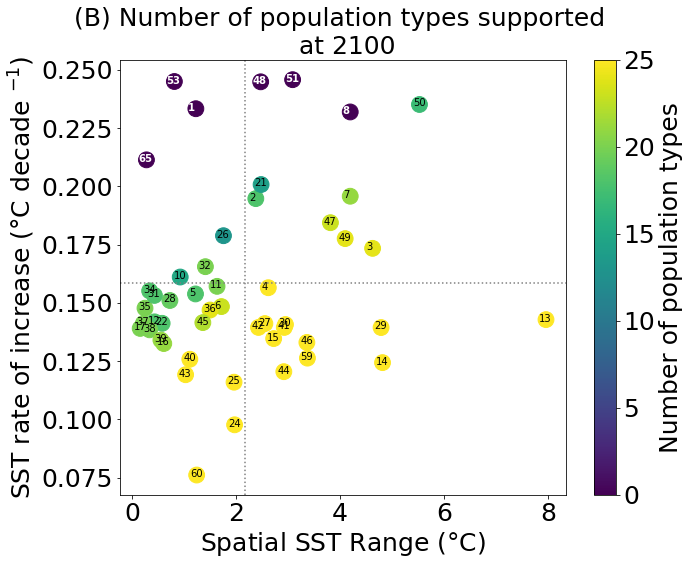

In [12]:
# Create a new figure
fig = plt.figure(figsize=(10,8))

# Add axes (subplots) to the figure
ax = fig.add_subplot(111)  # The argument (111) means 1x1 grid, first subplot
renamed_df.plot(kind='scatter',x='range', y='roc_45', c='Number of population types', cmap='viridis', s=250, ax=ax)

# Annotate points, designate white font for certain regions 
white_text = [1,8,48,51,53,65]

for i, txt in enumerate(df.region):
    if txt in white_text:
        ax.annotate(txt, (renamed_df.range[i]-0.15, renamed_df.roc_45[i]-0.0009), color='white', weight='bold', size=10)
    else:
        ax.annotate(txt, (renamed_df.range[i]-0.13, renamed_df.roc_45[i]-0.0008), size=10)
    
# Specify plot attributes  
# mpl.rcParams['font.size'] = 25
ax.axvline(x=np.mean(renamed_df['range']), color='grey', linestyle=':')
ax.axhline(y=np.mean(renamed_df['roc_45']), color='grey', linestyle=':')
ax.set_xlabel('Spatial SST Range ($\degree$C)', fontsize=25)
ax.set_ylabel('SST rate of increase ($\degree$C decade $^{-1}$)', fontsize=25)
ax.tick_params(axis='both', which='major',labelsize=25)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.title('(B) Number of population types supported \n at 2100', fontsize=25)

# plt.savefig('species_coord.png')

# Figure 4. Map w and V associated with highest abundance <a class="anchor" id="w,V"></a>

In [13]:
# Map data
def best(parameter):
    # Specify attributes CSV file to store dictionary
    column_names = ['region','w','V']
    filename = 'combination.csv' # change this name if necessary
    
    # Initialize variables
    N = dict() 
    coral = 0
    best_combination = {}
    rcp = 45

    # Combinations of w, V in order in which they are evaluated in loop
    index_combinations = ['0.5,0.01','0.5,0.0325','0.5,0.055','0.5,0.0775','0.5,0.1',
                    '0.625,0.01','0.625,0.0325','0.625,0.055','0.625,0.0775','0.625,0.1',
                    '0.75,0.01','0.75,0.0325','0.75,0.055','0.75,0.0775','0.75,0.1',
                    '0.875,0.01','0.875,0.0325','0.875,0.055','0.875,0.0775','0.875,0.1',
                    '1.0,0.01','1.0,0.0325','1.0,0.055','1.0,0.0775','1.0,0.1']

    for r in regions: # iterate over all regions
        abundance = []
        data = []
        averages = []
        for p in np.arange(0,20,1): # iterate over all 20 patches
            for w in w_array: # iterate over each w
                for V in V_array: # and V 
                    N[w, V] = np.load(str(path)+"/change_"+str(rcp)+"/N1_region_"+str(r)+"_w["+w+"]_V["+V+"].npy") # N1 for changing temperature simulation
                    abundance.append(N[w,V][p,coral,89]) # store abundance in list

        # Calculate average abundance across 20 patches for each w, V combination
        data = [abundance[p:p+25] for p in range(0,len(abundance),25)]
        averages = [sum(e)/len(e) for e in zip(*data)]

        # Find highest average abundance
        largest = np.max(averages)

        # Add values to dictionary
        if r in null_regions: 
            best_combination[r] = 'NaN','NaN'
        elif largest > 0.1: # if abundance above this threshold, add w, V combination to data
            i = averages.index(largest) # find index of highest average abundance
            best_combination[r] = tuple(index_combinations[i].split(",")) # add corresponding w, V to best_combination dict
        else: 
            best_combination[r] = 'NaN','NaN'

    # Write to file
    with open(filename,'w') as f:
        write = csv.writer(f)
        write.writerow(column_names)
        write.writerows((w,) + V for w, V in best_combination.items()) # unpack tuple into columns
    # Read file
    data = pd.read_csv(filename)

    # Merge shapefile and CSV
    fullData = geoData.merge(data, left_index=True, right_index=True)
        
    # Set figure    
    fig, ax = plt.subplots(1, 1, figsize=(35, 15))
    
    # Set font size of legend
    mpl.rcParams['font.size'] = 60
    
    # Discrete color map
    cmap = cm.get_cmap(parameter[0],5) 
    ax = fullData.plot(parameter[1], 
                  legend=True, 
                  legend_kwds={'label': parameter[1]}, 
                  missing_kwds={"color": "lightgrey"}, 
                  edgecolor='black',
                  cmap=cmap,
                  vmin = parameter[2], 
                  vmax = parameter[3],
                  ax=ax)
    
    ax.set_title(parameter[5] + ' Best ' + parameter[1] +': RCP' + (str(rcp)[0]+'.'+str(rcp)[1]), fontsize=60) 
    ax.tick_params(axis='both', which='major',labelsize=50)
    plt.rc('xtick', labelsize=50)
    plt.rc('ytick', labelsize=45)

    cb_ax = fig.axes[1] 
    cb_ax.tick_params(labelsize=50)
    cb_ax.set_yticks(parameter[4])
    cb_ax.set_yticklabels(parameter[4])
    
    plt.savefig("best_w_map.pdf")
    
    
interact(best, parameter = [('w', ['flare', 'w', 0.43, 1.07, [0.5, 0.625, 0.75, 0.875, 1.], '(A)']), 
                     ('V', ['crest', 'V', 0, 0.11, [0.01, 0.0325, 0.055, 0.0775, 0.1], '(B)'])]);
    

interactive(children=(Dropdown(description='parameter', options=(('w', ['flare', 'w', 0.43, 1.07, [0.5, 0.625,…

## Figure 4(C) and 4(D)

In [14]:
def histogram(parameter): 
    # Read file created above
    data = pd.read_csv('combination.csv')

    # Set figure    
    fig, ax = plt.subplots(1, 1, figsize=(35, 15))
    
    # Plot histogram
    plt.hist(x=data[parameter[0]], bins=parameter[4], color = 'olive', width=parameter[2], align='mid')
    plt.title(parameter[3] + ' Number of regions for each value of "Best ' + parameter[0] + '"', fontsize=80)
    plt.ylabel('Number of regions', fontsize=80)
    plt.xlabel(parameter[0], fontsize=80)
    plt.xticks(ticks=parameter[5], labels=parameter[1], fontsize=80)
    plt.yticks(fontsize=80)
    
    #plt.savefig("best_w_hist.pdf")
        
interact(histogram,
         parameter = [('Best w', ['w', [0.5, 0.625, 0.75, 0.875, 1.], 0.07, '(C)', [0.5, 0.6, 0.7, 0.8, 0.9, 1.], 
                                 [0.535, 0.635, 0.735, 0.835, 0.935]]),
                    ('Best V', ['V', [0.01, 0.0325, 0.055, 0.0775, 0.1], 0.015, '(D)', [0, 0.02, 0.04, 0.06, 0.08, 0.1],
                               [0.008, 0.028, 0.048, 0.068, 0.088]])
                     ]);  

interactive(children=(Dropdown(description='parameter', options=(('Best w', ['w', [0.5, 0.625, 0.75, 0.875, 1.…

## Figure 4(E) and 4(F)

In [15]:
def combination(parameter): 
    # Read file created above
    combination = pd.read_csv('combination.csv')

    # Read temperature file
    data = pd.read_csv('range_roc.csv')

    # Merge shapefile and CSV
    fullData = geoData.merge(data, left_index=True, right_index=True)

    # Set figure    
    fig, ax = plt.subplots(1, 1, figsize=(35, 15))

    # Plot histogram
    plt.scatter(parameter[1], combination[parameter[0]], s=800)
    plt.ylabel(parameter[0], fontsize=80)
    plt.xlabel(parameter[2], fontsize=80)
    plt.title(parameter[4], fontsize=80)
    plt.yticks(ticks=parameter[3], labels=parameter[3], fontsize=80)
    plt.xticks(fontsize=80)
    
interact(combination,
         parameter = [('Rate of increase, w', ['w', fullData['roc_45']*10, "SST rate of increase ($\degree$C decade$^{-1}$)",[0.5, 0.625, 0.75, 0.875, 1.],'(E) Rate of increase and "Best w"']),
                    ('Rate of increase, V', ['V', fullData['roc_45']*10, "SST rate of increase ($\degree$C decade$^{-1}$)",[0.01, 0.0325, 0.055, 0.0775, 0.1], '(F) Rate of increase and "Best V"']),
                     ]);

interactive(children=(Dropdown(description='parameter', options=(('Rate of increase, w', ['w', 0          NaN
…

## Figure 4(G) and 4(H)

In [16]:
def combination(parameter): 
    # Read file created for Figure 6
    combination = pd.read_csv('combination.csv')

    # Read temperature file
    data = pd.read_csv('range_roc.csv')

    # Merge shapefile and CSV
    fullData = geoData.merge(data, left_index=True, right_index=True)

    # Set figure    
    fig, ax = plt.subplots(1, 1, figsize=(35, 15))

    # Plot histogram
    plt.scatter(parameter[1], combination[parameter[0]], s=800)
    plt.ylabel(parameter[0], fontsize=80)
    plt.xlabel(parameter[2], fontsize=80)
    plt.title(parameter[4], fontsize=80)
    plt.yticks(ticks=parameter[3], labels=parameter[3], fontsize=80)
    plt.xticks(fontsize=80)
    
interact(combination,
         parameter = [('Range, w', ['w', fullData['range'], "Spatial SST range ($\degree$C)",[0.5, 0.625, 0.75, 0.875, 1.],'(G) Spatial range and "Best w"']),
                    ('Range, V', ['V', fullData['range'], "Spatial SST range ($\degree$C)",[0.01, 0.0325, 0.055, 0.0775, 0.1], '(H) Spatial range and "Best V"']),
                     ]);

interactive(children=(Dropdown(description='parameter', options=(('Range, w', ['w', 0          NaN
1          …

# Figure 5. Patch contribution plots <a class="anchor" id="Composition"></a>

## Figure 5(A)-5(C)

Generate plots for different patch temperatures by specifying "i_array" value in the following cell.

In [16]:
# Initialize lists
i_array = [0, 19] #warmest patches=[0, 19]; coolest patches=[9, 10]; intermediate patches=[4,15]
coral = 0
list_average = []
abundance = []
trait = []
sst = []
mismatch_region = []

rcp = 45

for r in regions: 
    if r in null_regions: 
        continue
    else: 
        N = dict()
        Z = dict()
        SST = dict()
        for i in i_array: 
            for w in w_array: 
                for V in V_array:  
                    # Load abundance (N), trait value (Z), and SST 
                    N[w, V] = np.load(str(path)+"/change_"+str(rcp)+"/N1_region_"+str(r)+"_w["+w+"]_V["+V+"].npy")
                    Z[w, V] = np.load(str(path)+"/change_"+str(rcp)+"/Z1_region_"+str(r)+"_w["+w+"]_V["+V+"].npy")
                    SST[w, V] = np.load(str(path)+"/change_"+str(rcp)+"/SST1_region_"+str(r)+"_w["+w+"]_V["+V+"].npy")
                    abundance.append(N[w,V][i,coral,89])
                    trait.append(Z[w,V][i,coral,89])
                    sst.append(SST[w,V][i,89])
        
        # Compute average abundance for each w, V combination
        data = [abundance[i:i+25] for i in range(0,len(abundance),25)]
        numbers = [sum(e)/len(e) for e in zip(*data)]

        # Compute average trait mismatch for each w, V combination
        mismatch = np.array(sst) - np.array(trait)
        concat_mis = [mismatch[i:i+25] for i in range(0,len(mismatch),25)]
        avg_mismatch = [sum(e)/len(e) for e in zip(*concat_mis)]

        list_average.append(numbers)
        mismatch_region.append(avg_mismatch)
        
# Compute average abundance and mismatch across all regions
average = [sum(e)/len(e) for e in zip(*list_average)]
overall_mismatch = [sum(e)/len(e) for e in zip(*mismatch_region)]

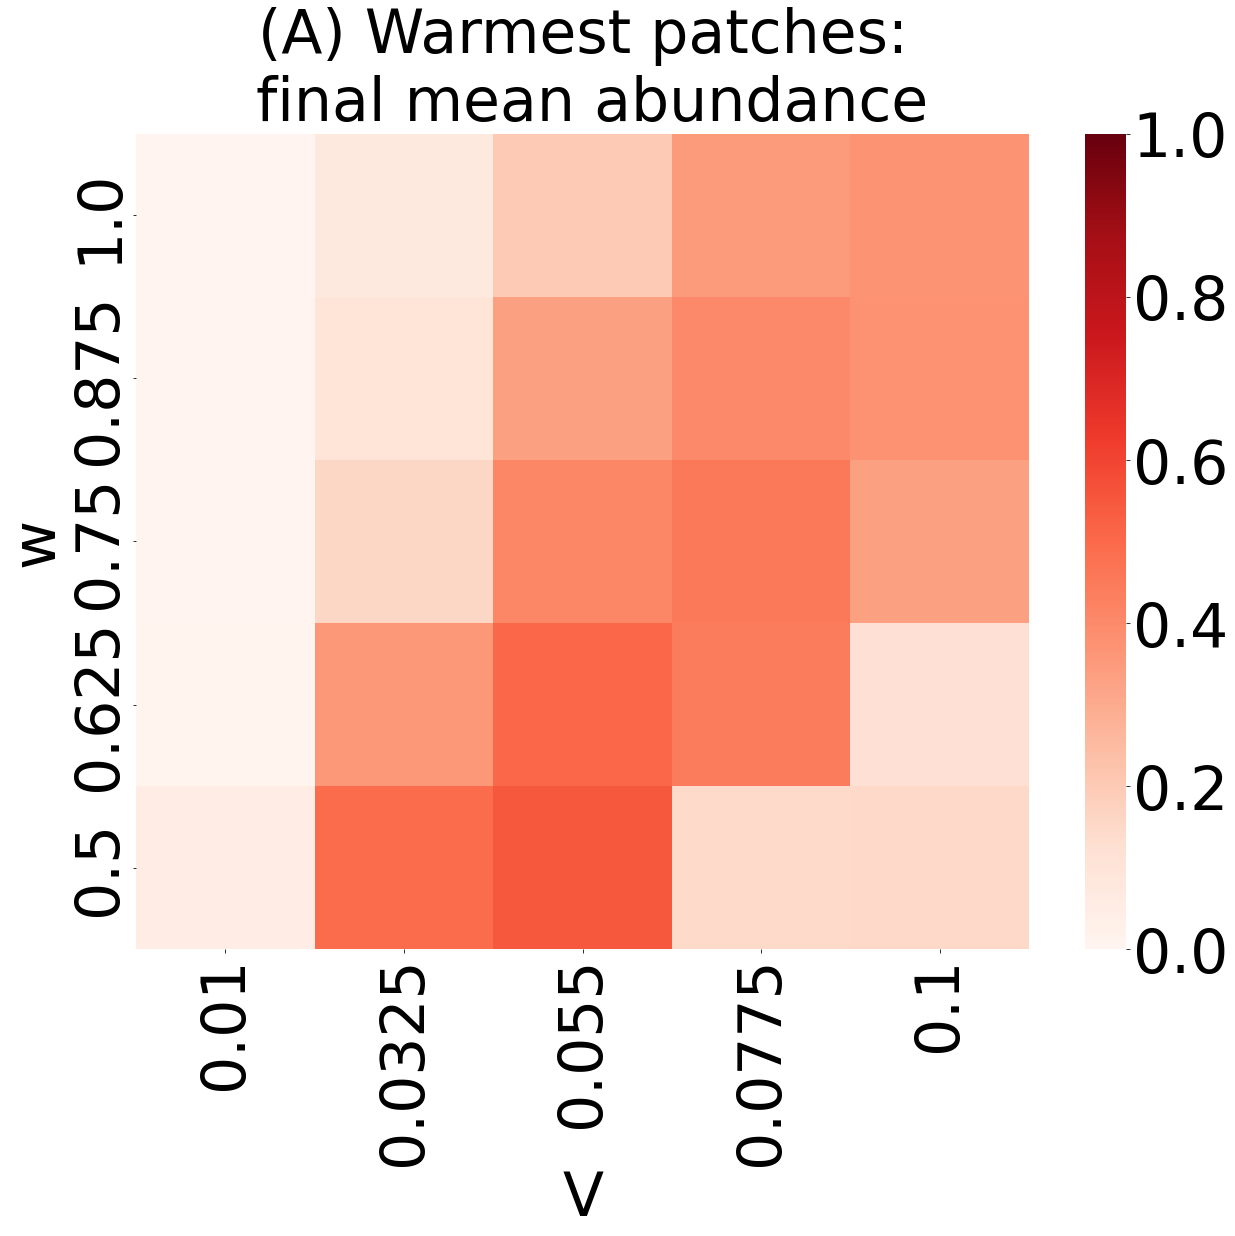

In [17]:
# Plot abundance heatmaps
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

data = {'w': np.repeat([0.5, 0.625, 0.75, 0.875, 1. ], 5), 
        'V': np.tile([0.01, 0.0325, 0.055, 0.0775, 0.1 ], 5),
        'N': average}


df = pd.DataFrame(data, columns = ['w','V','N'])
df = df.pivot('w','V', 'N')
df.sort_index(level=0, ascending=False, inplace=True)

if i_array == [0, 19]: 
    ax.set_title("(A) Warmest patches:\n final mean abundance", size=60)
    sns.heatmap(df, vmin=0.0, vmax=1.0, cmap="Reds")

elif i_array == [9, 10]: 
    ax.set_title("(B) Coolest patches:\n final mean abundance", size=60)
    sns.heatmap(df, vmin=0.0, vmax=1.0, cmap="Blues")
    
elif i_array == [4, 15]: 
    ax.set_title("(C) Intermediate patches:\n final mean abundance", size=60)
    sns.heatmap(df, vmin=0.0, vmax=1.0, cmap="Greens")

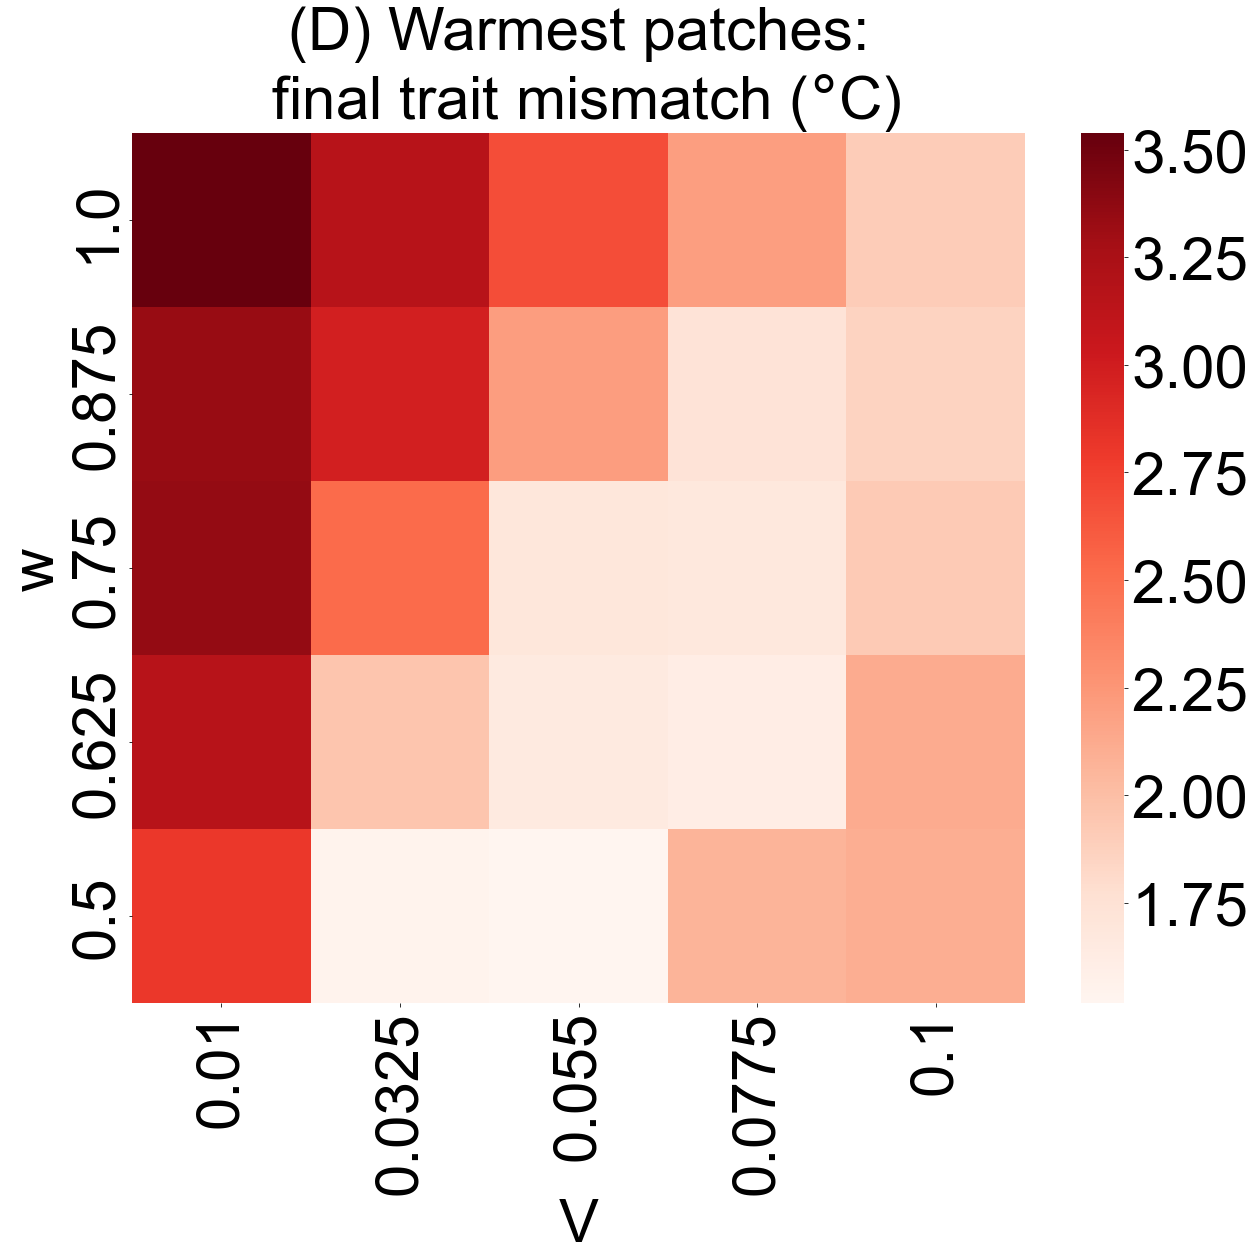

In [18]:
# Plot trait mismatch heatmaps 
fig, ax = plt.subplots(1, 1, figsize=(20, 16))

data = {'w': np.repeat([0.5, 0.625, 0.75, 0.875, 1. ], 5), 
        'V': np.tile([0.01, 0.0325, 0.055, 0.0775, 0.1 ], 5),
        'N': overall_mismatch}

df = pd.DataFrame(data, columns = ['w','V','N'])
df = df.pivot('w','V', 'N')
df.sort_index(level=0, ascending=False, inplace=True)

if i_array == [0, 19]: 
    ax.set_title("(D) Warmest patches:\n final trait mismatch ($\degree$C)", size=60)
    sns.heatmap(df, cmap="Reds")
    sns.set(font_scale=2)

elif i_array == [9, 10]: 
    ax.set_title("(E) Coolest patches:\n final trait mismatch ($\degree$C)", size=60)
    sns.heatmap(df, cmap="Blues")
    
elif i_array == [4, 15]: 
    ax.set_title("(F) Intermediate patches:\n final trait mismatch ($\degree$C)", size=60)
    sns.heatmap(df, cmap="Greens")

# Figure S1. Species supported at end of burn-in period <a class="anchor" id="burn-in"></a>

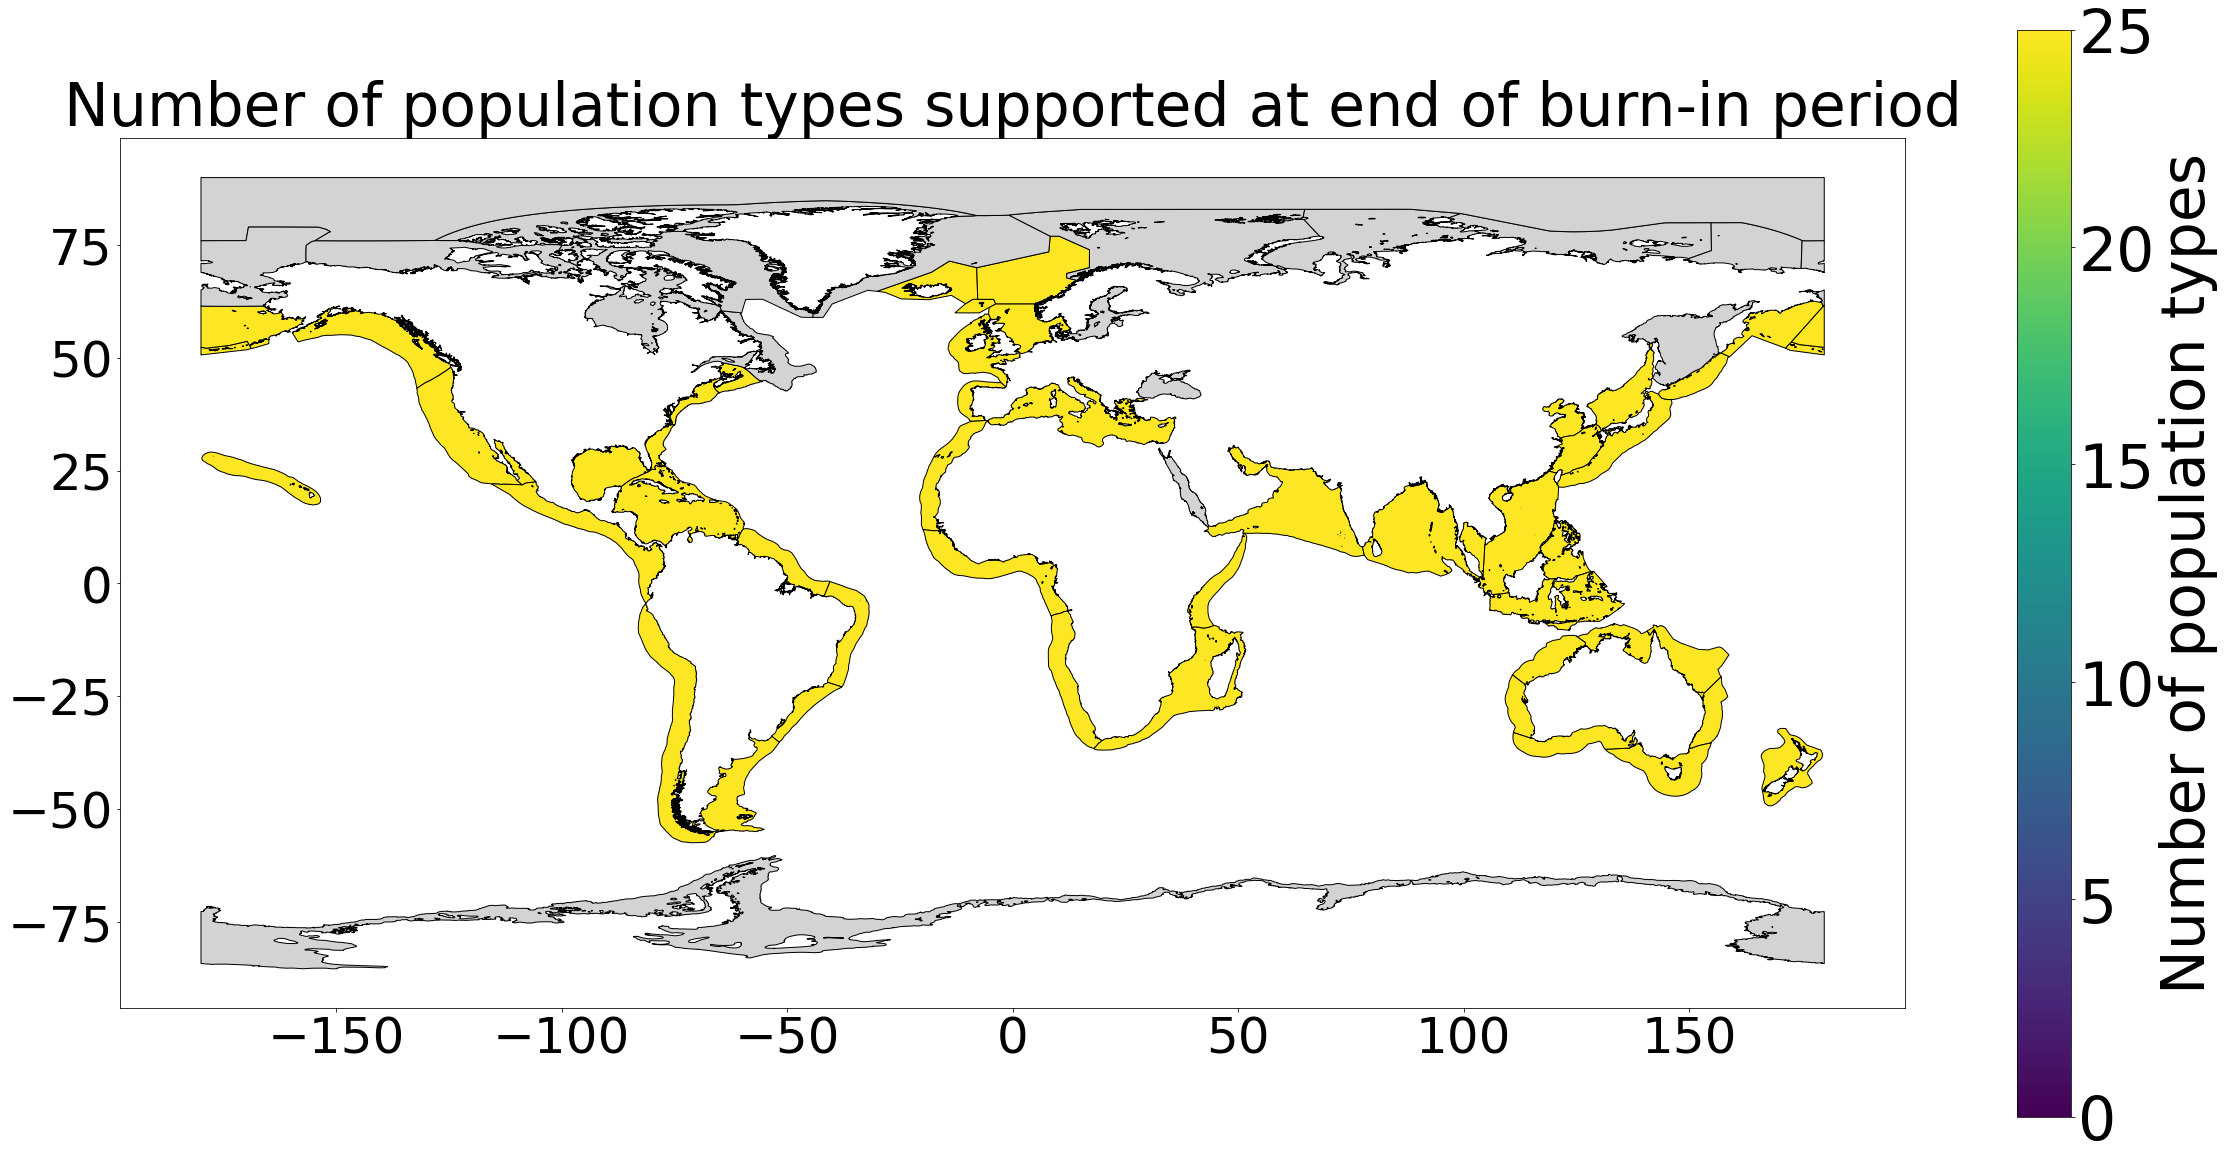

In [6]:
# Initialize variables
N = dict() 
coral = 0
species_supported = {}
rcp = 45

# Combinations of w, V in order in which they are evaluated in loop
index_combinations = ['0.5,0.01','0.5,0.0325','0.5,0.055','0.5,0.0775','0.5,0.1',
                        '0.625,0.01','0.625,0.0325','0.625,0.055','0.625,0.0775','0.625,0.1',
                        '0.75,0.01','0.75,0.0325','0.75,0.055','0.75,0.0775','0.75,0.1',
                        '0.875,0.01','0.875,0.0325','0.875,0.055','0.875,0.0775','0.875,0.1',
                        '1.0,0.01','1.0,0.0325','1.0,0.055','1.0,0.0775','1.0,0.1']

for r in regions: # iterate over all regions
    abundance = []
    data = []
    averages = []
    supported = 0
    for p in np.arange(0,20,1): # iterate over all 20 patches
        for w in w_array: # iterate over each w
            for V in V_array: # and V 
                N[w, V] = np.load(str(path)+"/change_"+str(rcp)+"/N1_region_"+str(r)+"_w["+w+"]_V["+V+"].npy") #N1 for changing temperature simulation
                abundance.append(N[w,V][p,coral,0]) # store abundance in list

    # Calculate average abundance across 20 patches for each w, V combination
    data = [abundance[p:p+25] for p in range(0,len(abundance),25)]
    averages = [sum(e)/len(e) for e in zip(*data)]

    # Increase value of "supported" for each average abundance above threshold 0.1 
    for a in averages: 
        if a > 0.1: 
            supported += 1

    # Add values to dictionary
    if r in null_regions: 
        species_supported[r] = 'NaN'
    else: 
        species_supported[r] = supported

# Store dictionary in a CSV file
column_names = ['region','number']
filename = 'burn-in_species_supported.csv' # change this name if necessary

# Write to file
with open(filename,'w') as f:
    write = csv.writer(f)
    write.writerow(column_names)
    write.writerows(species_supported.items())

# Read file
data = pd.read_csv(filename)

# Merge shapefile and CSV
fullData = geoData.merge(data, left_index=True, right_index=True)

fig, ax = plt.subplots(1, 1, figsize=(40, 20))

# Set title
parameter = 'Number of population types supported'
# Set font size of legend
mpl.rcParams['font.size'] = 60

# Map data 
fullData.plot('number', 
                legend=True, 
                legend_kwds={'label': "Number of population types"}, 
                missing_kwds={"color": "lightgrey"}, 
                edgecolor='black',
                cmap='viridis',
                vmin = 0, 
                vmax = 25,
                ax=ax)

ax.set_title('Number of population types supported at end of burn-in period' , fontsize=60) 
ax.tick_params(axis='both', which='major',labelsize=50)
plt.rc('xtick', labelsize=50)
plt.rc('ytick', labelsize=50)

# Figures S3-6 <a class="anchor" id="evolution"></a>

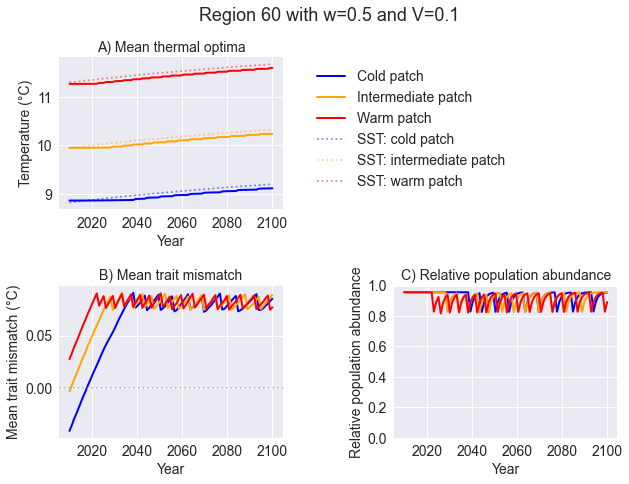

In [8]:
ID = 60
FS1 = 14
FS2 = 14
FS3 = 18

# Load data for both population types
# Population 1: w=0.5, V=0.1
N1 = np.load(str(path)+"/change_45/N1_region_"+str(ID)+"_w[0.5]_V[0.1].npy").squeeze()
Z1 = np.load(str(path)+"/change_45/Z1_region_"+str(ID)+"_w[0.5]_V[0.1].npy").squeeze()
SST1 = np.load(str(path)+"/change_45/SST1_region_"+str(ID)+"_w[0.5]_V[0.1].npy")

# Create time array
years = np.linspace(2010, 2100, 90)

# Set up figure
plt.style.use('seaborn')
fig = plt.figure(figsize=(10, 7))
gs = GridSpec(2, 2, figure=fig)

# Color schemes
colors1 = ['blue', 'orange', 'red']  # For narrow tolerance
patches_to_show = [9, 5, 0]   # Cold, middle, and warm patches
labels = ['Cold patch', 'Intermediate patch', 'Warm patch']

# Panel A: Evolution of thermal optima
ax1 = fig.add_subplot(gs[0, 0])

# Plot for narrow tolerance (w=0.5)
for i, patch in enumerate(patches_to_show):
    ax1.plot(years, Z1[patch], color=colors1[i], label=f'{labels[i]}', linewidth=2)
    
# Plot temperature for reference (same for both)
ax1.plot(years, SST1[patches_to_show[0]], color='blue', linestyle=':', label='SST: cold patch', alpha=0.5)
ax1.plot(years, SST1[patches_to_show[1]], color='orange', linestyle=':', label='SST: intermediate patch', alpha=0.5)
ax1.plot(years, SST1[patches_to_show[2]], color='red', linestyle=':', label='SST: warm patch', alpha=0.5)

ax1.set_xlabel('Year', fontsize=FS1)
ax1.set_ylabel('Temperature (°C)', fontsize=FS1)
ax1.set_title('A) Mean thermal optima', fontsize=FS1)
ax1.legend(bbox_to_anchor=(1.1, 1), loc='upper left', fontsize=FS1)


# Panel B: Trait mismatch
ax2 = fig.add_subplot(gs[1, 0])

for i, patch in enumerate(patches_to_show):
    lag1 = SST1[patch] - Z1[patch]
    ax2.plot(years, lag1, color=colors1[i], label=f'{labels[i]}', linewidth=2)

ax2.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Year', fontsize=FS1)
ax2.set_ylabel('Mean trait mismatch (°C)', fontsize=FS1)
ax2.set_title('B) Mean trait mismatch', fontsize=FS1)
#ax3.set_ylim([-0.0,0.5])

# Panel C: Population abundance
ax3 = fig.add_subplot(gs[1, 1])

for i, patch in enumerate(patches_to_show):
    ax3.plot(years, N1[patch], color=colors1[i], label=f'{labels[i]}', linewidth=2)

ax3.set_xlabel('Year', fontsize=FS1)
ax3.set_ylabel('Relative population abundance', fontsize=FS1)
ax3.set_title('C) Relative population abundance', fontsize=FS1)
ax3.set_ylim([0,1])



# Increase the font size of the tick labels
ax1.tick_params(axis='both', which='major', labelsize=FS2)
ax2.tick_params(axis='both', which='major', labelsize=FS2)
ax3.tick_params(axis='both', which='major', labelsize=FS2)


# Set title
fig.suptitle('Region '+str(ID)+' with w=0.5 and V=0.1', y=0.98, fontsize=FS3)
plt.subplots_adjust(wspace=0.5, hspace=0.5)


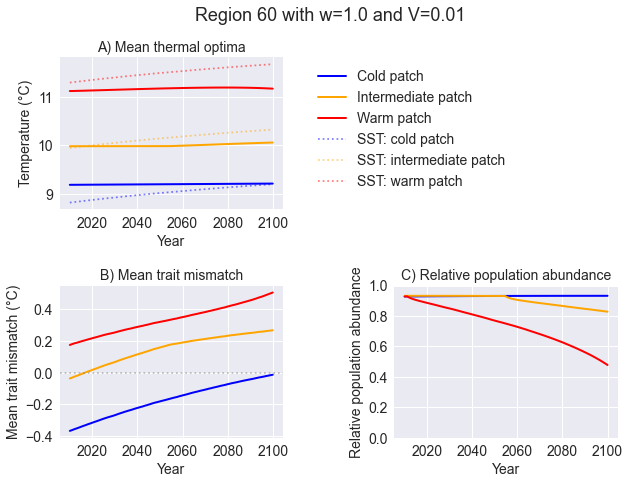

In [9]:
ID = 60

# Load data for both population types
# Population 1: w=0.5, V=0.1
N1 = np.load(str(path)+"/change_45/N1_region_"+str(ID)+"_w[1.]_V[0.01].npy").squeeze()
Z1 = np.load(str(path)+"/change_45/Z1_region_"+str(ID)+"_w[1.]_V[0.01].npy").squeeze()
SST1 = np.load(str(path)+"/change_45/SST1_region_"+str(ID)+"_w[1.]_V[0.01].npy")

# Create time array
years = np.linspace(2010, 2100, 90)

# Set up figure
plt.style.use('seaborn')
fig = plt.figure(figsize=(10, 7))
gs = GridSpec(2, 2, figure=fig)

# Color schemes
colors1 = ['blue', 'orange', 'red']  # For narrow tolerance
patches_to_show = [9, 5, 0]   # Cold, middle, and warm patches
labels = ['Cold patch', 'Intermediate patch', 'Warm patch']

# Panel A: Evolution of thermal optima
ax1 = fig.add_subplot(gs[0, 0])

# Plot for narrow tolerance (w=0.5)
for i, patch in enumerate(patches_to_show):
    ax1.plot(years, Z1[patch], color=colors1[i], label=f'{labels[i]}', linewidth=2)
    
# Plot temperature for reference (same for both)
ax1.plot(years, SST1[patches_to_show[0]], color='blue', linestyle=':', label='SST: cold patch', alpha=0.5)
ax1.plot(years, SST1[patches_to_show[1]], color='orange', linestyle=':', label='SST: intermediate patch', alpha=0.5)
ax1.plot(years, SST1[patches_to_show[2]], color='red', linestyle=':', label='SST: warm patch', alpha=0.5)

ax1.set_xlabel('Year', fontsize=FS1)
ax1.set_ylabel('Temperature (°C)', fontsize=FS1)
ax1.set_title('A) Mean thermal optima', fontsize=FS1)
ax1.legend(bbox_to_anchor=(1.1, 1), loc='upper left', fontsize=FS1)


# Panel B: Trait mismatch
ax2 = fig.add_subplot(gs[1, 0])

for i, patch in enumerate(patches_to_show):
    lag1 = SST1[patch] - Z1[patch]
    ax2.plot(years, lag1, color=colors1[i], label=f'{labels[i]}', linewidth=2)

ax2.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Year', fontsize=FS1)
ax2.set_ylabel('Mean trait mismatch (°C)', fontsize=FS1)
ax2.set_title('B) Mean trait mismatch', fontsize=FS1)
#ax3.set_ylim([-0.0,0.5])

# Panel C: Population abundance
ax3 = fig.add_subplot(gs[1, 1])

for i, patch in enumerate(patches_to_show):
    ax3.plot(years, N1[patch], color=colors1[i], label=f'{labels[i]}', linewidth=2)

ax3.set_xlabel('Year', fontsize=FS1)
ax3.set_ylabel('Relative population abundance', fontsize=FS1)
ax3.set_title('C) Relative population abundance', fontsize=FS1)
ax3.set_ylim([0,1])



# Increase the font size of the tick labels
ax1.tick_params(axis='both', which='major', labelsize=FS2)
ax2.tick_params(axis='both', which='major', labelsize=FS2)
ax3.tick_params(axis='both', which='major', labelsize=FS2)


# Set title
fig.suptitle('Region '+str(ID)+' with w=1.0 and V=0.01', y=0.98, fontsize=FS3)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

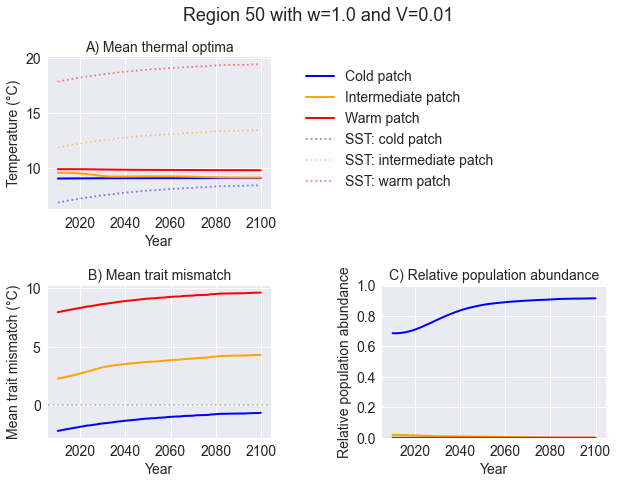

In [10]:
ID = 50

# Load data for both population types
# Population 1: w=0.5, V=0.1
N1 = np.load(str(path)+"/change_45/N1_region_"+str(ID)+"_w[1.]_V[0.01].npy").squeeze()
Z1 = np.load(str(path)+"/change_45/Z1_region_"+str(ID)+"_w[1.]_V[0.01].npy").squeeze()
SST1 = np.load(str(path)+"/change_45/SST1_region_"+str(ID)+"_w[1.]_V[0.01].npy")

# Create time array
years = np.linspace(2010, 2100, 90)

# Set up figure
plt.style.use('seaborn')
fig = plt.figure(figsize=(10, 7))
gs = GridSpec(2, 2, figure=fig)

# Color schemes
colors1 = ['blue', 'orange', 'red']  # For narrow tolerance
patches_to_show = [9, 5, 0]   # Cold, middle, and warm patches
labels = ['Cold patch', 'Intermediate patch', 'Warm patch']

# Panel A: Evolution of thermal optima
ax1 = fig.add_subplot(gs[0, 0])

# Plot for narrow tolerance (w=0.5)
for i, patch in enumerate(patches_to_show):
    ax1.plot(years, Z1[patch], color=colors1[i], label=f'{labels[i]}', linewidth=2)
    
# Plot temperature for reference (same for both)
ax1.plot(years, SST1[patches_to_show[0]], color='blue', linestyle=':', label='SST: cold patch', alpha=0.5)
ax1.plot(years, SST1[patches_to_show[1]], color='orange', linestyle=':', label='SST: intermediate patch', alpha=0.5)
ax1.plot(years, SST1[patches_to_show[2]], color='red', linestyle=':', label='SST: warm patch', alpha=0.5)

ax1.set_xlabel('Year', fontsize=FS1)
ax1.set_ylabel('Temperature (°C)', fontsize=FS1)
ax1.set_title('A) Mean thermal optima', fontsize=FS1)
ax1.legend(bbox_to_anchor=(1.1, 1), loc='upper left', fontsize=FS1)


# Panel B: Trait mismatch
ax2 = fig.add_subplot(gs[1, 0])

for i, patch in enumerate(patches_to_show):
    lag1 = SST1[patch] - Z1[patch]
    ax2.plot(years, lag1, color=colors1[i], label=f'{labels[i]}', linewidth=2)

ax2.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Year', fontsize=FS1)
ax2.set_ylabel('Mean trait mismatch (°C)', fontsize=FS1)
ax2.set_title('B) Mean trait mismatch', fontsize=FS1)
#ax3.set_ylim([-0.0,0.5])

# Panel C: Population abundance
ax3 = fig.add_subplot(gs[1, 1])

for i, patch in enumerate(patches_to_show):
    ax3.plot(years, N1[patch], color=colors1[i], label=f'{labels[i]}', linewidth=2)

ax3.set_xlabel('Year', fontsize=FS1)
ax3.set_ylabel('Relative population abundance', fontsize=FS1)
ax3.set_title('C) Relative population abundance', fontsize=FS1)
ax3.set_ylim([0,1])

# Increase the font size of the tick labels
ax1.tick_params(axis='both', which='major', labelsize=FS2)
ax2.tick_params(axis='both', which='major', labelsize=FS2)
ax3.tick_params(axis='both', which='major', labelsize=FS2)

# Set title
fig.suptitle('Region '+str(ID)+' with w=1.0 and V=0.01', y=0.98, fontsize=FS3)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

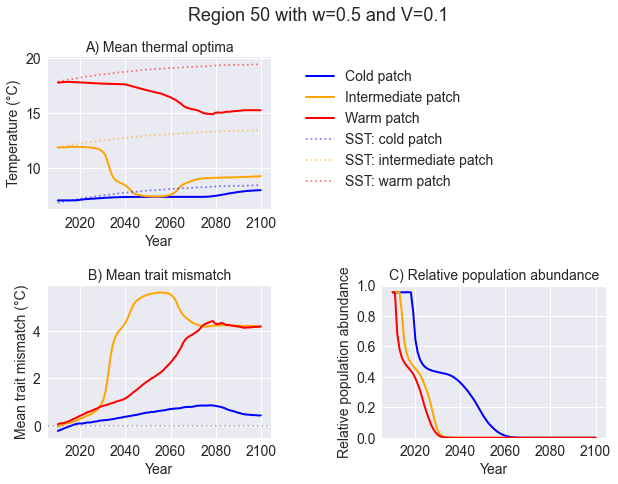

In [11]:
ID = 50

# Load data for both population types
# Population 1: w=0.5, V=0.1
N1 = np.load(str(path)+"/change_45/N1_region_"+str(ID)+"_w[0.5]_V[0.1].npy").squeeze()
Z1 = np.load(str(path)+"/change_45/Z1_region_"+str(ID)+"_w[0.5]_V[0.1].npy").squeeze()
SST1 = np.load(str(path)+"/change_45/SST1_region_"+str(ID)+"_w[0.5]_V[0.1].npy")

# Create time array
years = np.linspace(2010, 2100, 90)

# Set up figure
plt.style.use('seaborn')
fig = plt.figure(figsize=(10, 7))
gs = GridSpec(2, 2, figure=fig)

# Color schemes
colors1 = ['blue', 'orange', 'red']  # For narrow tolerance
patches_to_show = [9, 5, 0]   # Cold, middle, and warm patches
labels = ['Cold patch', 'Intermediate patch', 'Warm patch']

# Panel A: Evolution of thermal optima
ax1 = fig.add_subplot(gs[0, 0])

# Plot for narrow tolerance (w=0.5)
for i, patch in enumerate(patches_to_show):
    ax1.plot(years, Z1[patch], color=colors1[i], label=f'{labels[i]}', linewidth=2)
    
# Plot temperature for reference (same for both)
ax1.plot(years, SST1[patches_to_show[0]], color='blue', linestyle=':', label='SST: cold patch', alpha=0.5)
ax1.plot(years, SST1[patches_to_show[1]], color='orange', linestyle=':', label='SST: intermediate patch', alpha=0.5)
ax1.plot(years, SST1[patches_to_show[2]], color='red', linestyle=':', label='SST: warm patch', alpha=0.5)

ax1.set_xlabel('Year', fontsize=FS1)
ax1.set_ylabel('Temperature (°C)', fontsize=FS1)
ax1.set_title('A) Mean thermal optima', fontsize=FS1)
ax1.legend(bbox_to_anchor=(1.1, 1), loc='upper left', fontsize=FS1)


# Panel B: Trait mismatch
ax2 = fig.add_subplot(gs[1, 0])

for i, patch in enumerate(patches_to_show):
    lag1 = SST1[patch] - Z1[patch]
    ax2.plot(years, lag1, color=colors1[i], label=f'{labels[i]}', linewidth=2)

ax2.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Year', fontsize=FS1)
ax2.set_ylabel('Mean trait mismatch (°C)', fontsize=FS1)
ax2.set_title('B) Mean trait mismatch', fontsize=FS1)
#ax3.set_ylim([-0.0,0.5])

# Panel C: Population abundance
ax3 = fig.add_subplot(gs[1, 1])

for i, patch in enumerate(patches_to_show):
    ax3.plot(years, N1[patch], color=colors1[i], label=f'{labels[i]}', linewidth=2)

ax3.set_xlabel('Year', fontsize=FS1)
ax3.set_ylabel('Relative population abundance', fontsize=FS1)
ax3.set_title('C) Relative population abundance', fontsize=FS1)
ax3.set_ylim([0,1])

# Increase the font size of the tick labels
ax1.tick_params(axis='both', which='major', labelsize=FS2)
ax2.tick_params(axis='both', which='major', labelsize=FS2)
ax3.tick_params(axis='both', which='major', labelsize=FS2)

# Set title
fig.suptitle('Region '+str(ID)+' with w=0.5 and V=0.1', y=0.98, fontsize=FS3)
plt.subplots_adjust(wspace=0.5, hspace=0.5)